In [26]:
import numpy as np

import pandas as pd

import xgboost as xgb

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from xgboost import plot_importance

from sklearn import preprocessing 

dtrain=pd.read_csv("C:\\Users\\user80917\\Desktop\\CBC_dataset\\CBC-Sent.csv")
data_test=pd.read_csv("C:\\Users\\user80917\\Desktop\\CBC_dataset\\CBC-Candidate.csv")

dtrain=dtrain.drop(columns=['Seq'])
dtest=data_test.drop(columns=['Seq','Florence'])

dtrain


,Gender,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeoBks,ItalCook,ItalAtlas,ItalArt,Related purchase,Florence
0,1,477,20,12,68,2,1,5,0,0,1,3,1,0,0,5,0
1,1,475,4,12,52,4,0,2,2,1,0,1,0,0,0,1,0
2,0,472,8,12,58,4,0,3,1,1,0,0,0,0,1,1,0
3,1,466,8,12,62,2,1,4,0,0,1,3,1,1,0,6,0
4,0,465,6,12,74,0,3,2,3,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,17,4,1,4,0,0,0,0,0,0,0,0,0,0,0,0
2996,1,17,12,1,12,0,0,0,0,0,0,0,0,0,0,0,0
2997,1,16,8,1,8,0,0,0,0,0,3,0,0,0,0,3,0
2998,0,15,34,1,34,0,0,0,1,0,0,0,0,0,0,0,0


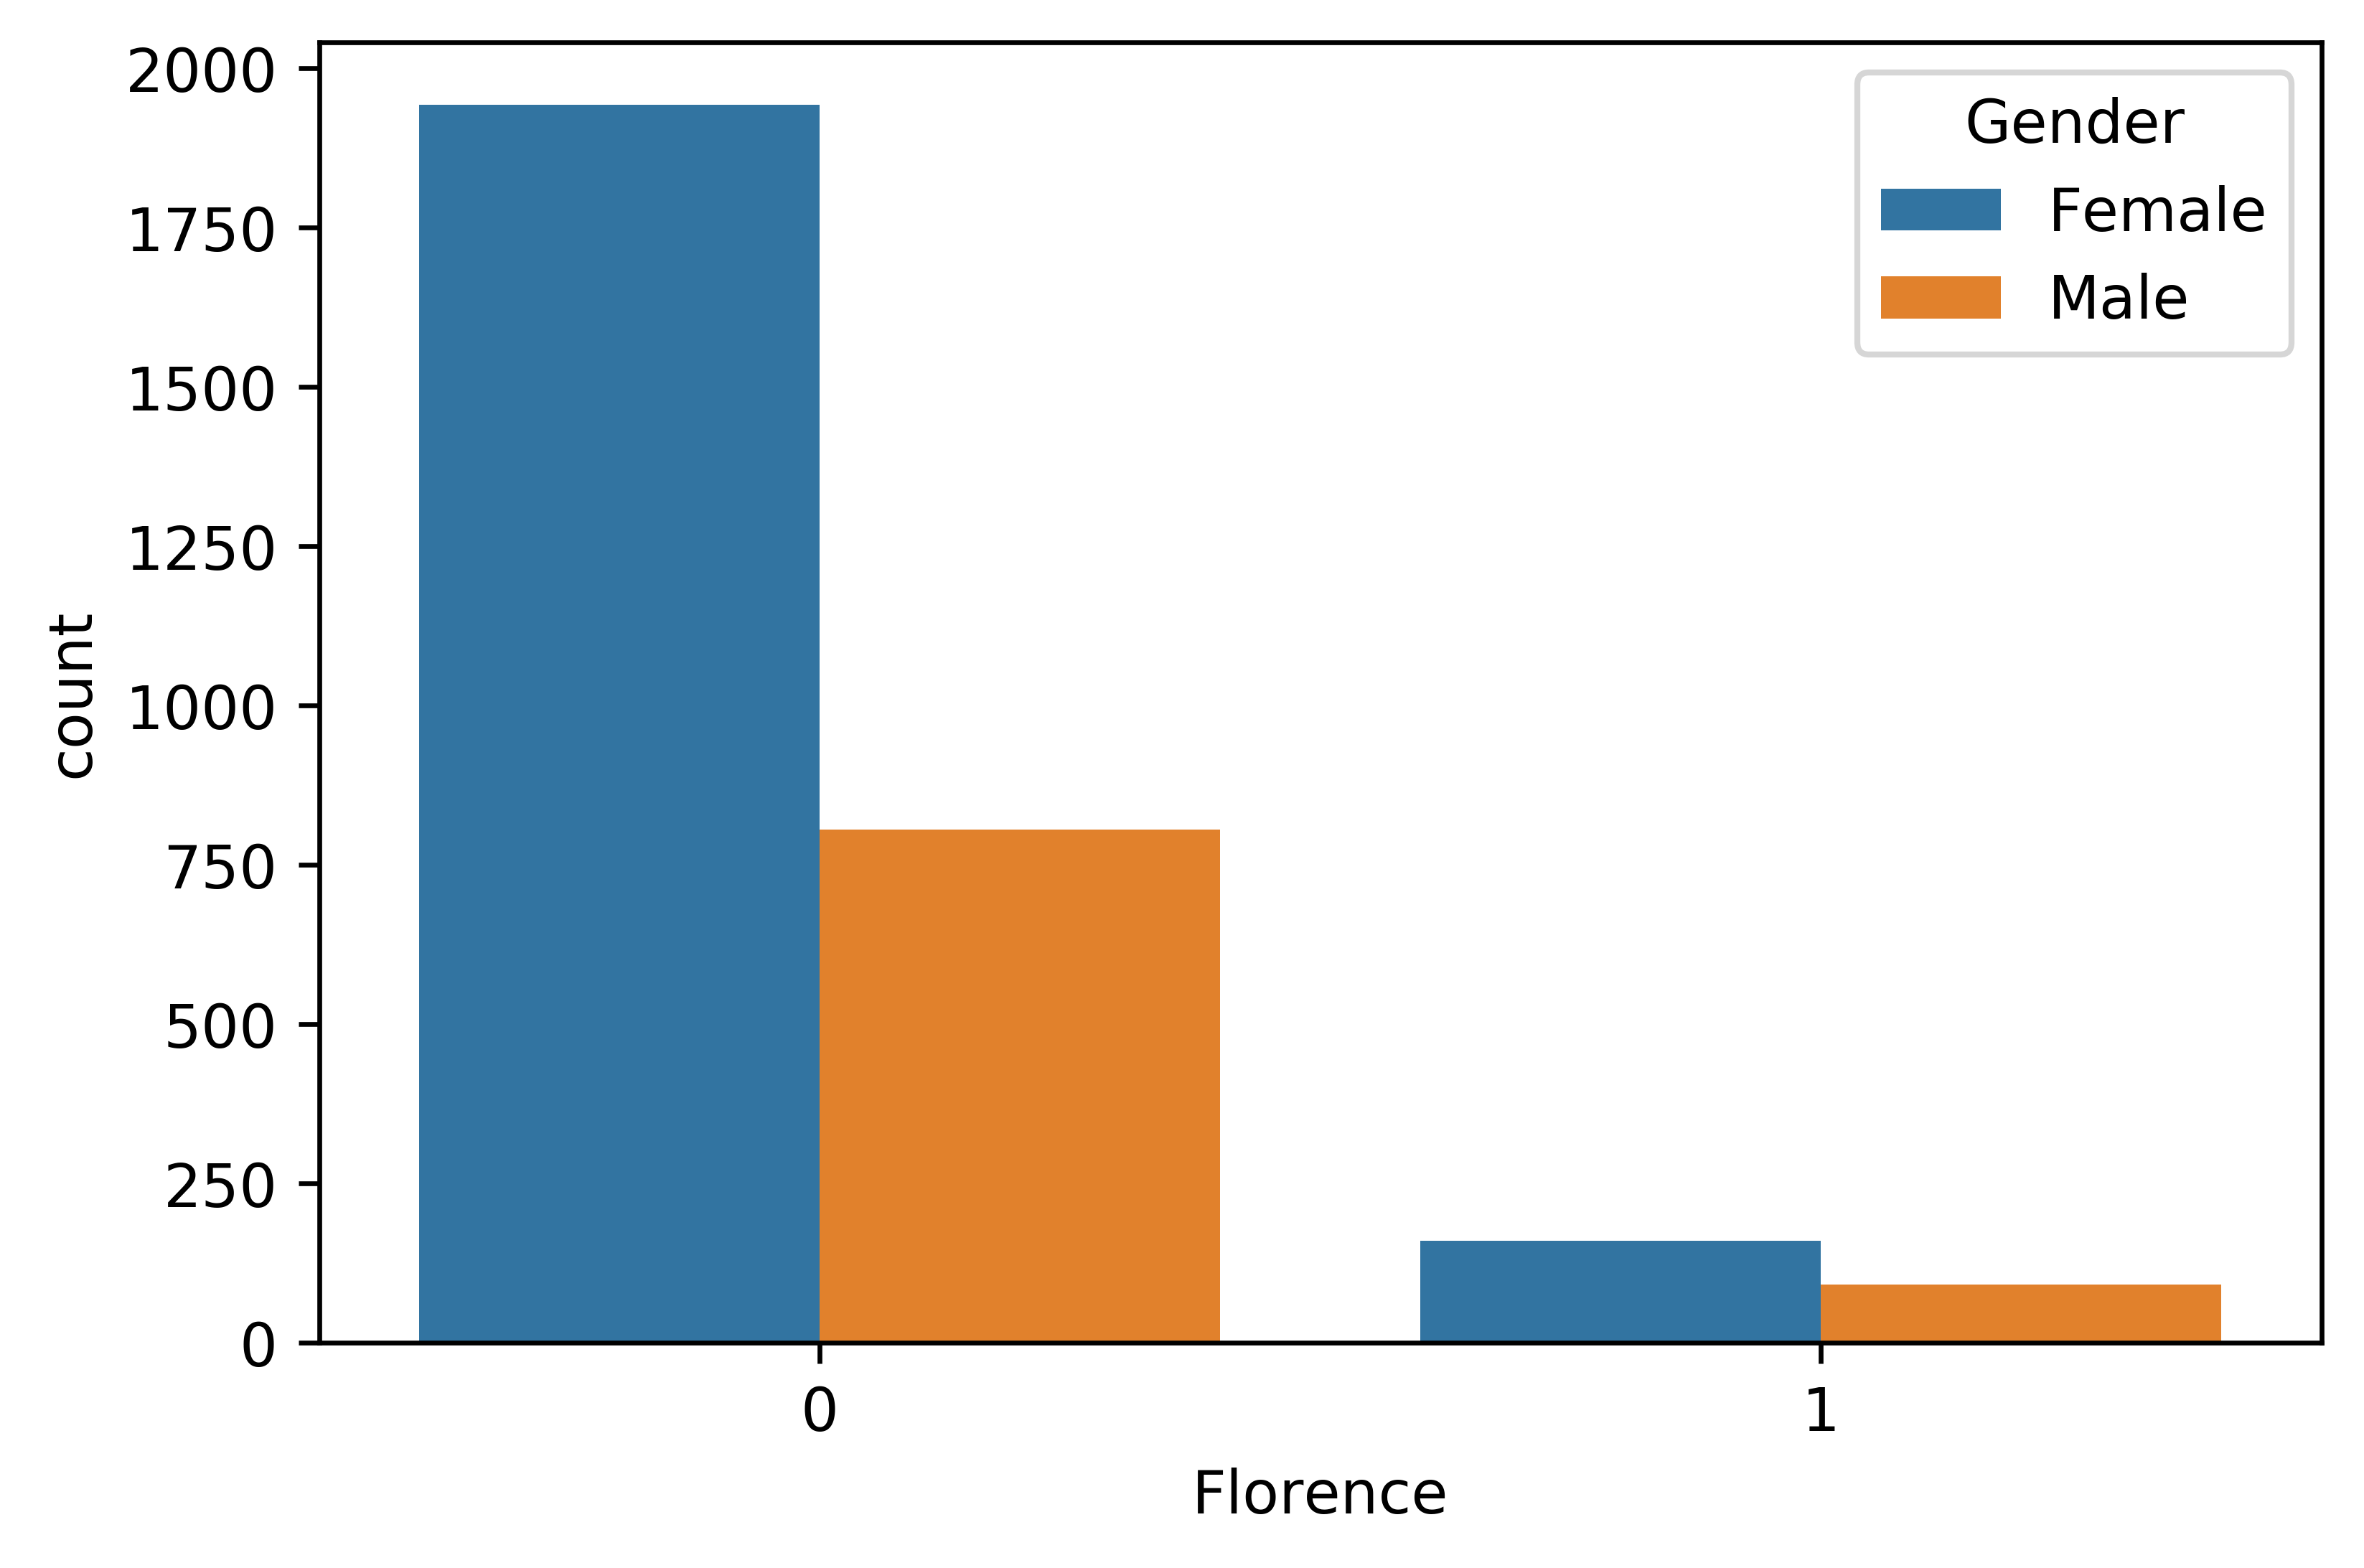

In [27]:
#多少人買書count
import seaborn as sns
dtrain['Gender'].replace(0, 'Male',inplace=True)
dtrain['Gender'].replace(1, 'Female',inplace=True)

g=sns.countplot(x='Florence',hue='Gender',data=dtrain)

In [28]:
def preprocess(df):
    
    df['Gender'].replace(0, 'Male',inplace=True)
    df['Gender'].replace(1, 'Female',inplace=True)

    # One-hot Encoding Gender
    d_Gender=pd.get_dummies(df['Gender'],prefix='Gender')
    df=pd.concat([df,d_Gender],axis=1)
    df.drop(['Gender'],axis=1,inplace=True)
   
    
    # Convert all columns of DataFrame
    df = df.apply(pd.to_numeric) 
    
    # Customers Seperation
    df['High-knowledge Parents']=df['ChildBks']+df['ArtBks']+df['GeoBks']+df['CookBks']
    df['Teens']=df['DoItYBks']+df['YouthBks']+df['RefBks']
    
    # One-hot Encoding .*Bks
    df.loc[df['ChildBks'] >= 1, 'ChildBks'] = 1
    df.loc[df['YouthBks'] >= 1, 'YouthBks'] = 1
    df.loc[df['CookBks'] >= 1, 'CookBks'] = 1
    df.loc[df['DoItYBks'] >= 1, 'DoItYBks'] = 1
    df.loc[df['RefBks'] >= 1, 'RefBks'] = 1
    df.loc[df['ArtBks'] >= 1, 'ArtBks'] = 1
    df.loc[df['GeoBks'] >= 1, 'GeoBks'] = 1
    df.loc[df['ItalCook'] >= 1, 'ItalCook'] = 1
    df.loc[df['ItalAtlas'] >= 1, 'ItalAtlas'] = 1
    df.loc[df['ItalArt'] >= 1, 'ItalArt'] = 1
    
    #Min-Max Scaler
    Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) 
    M_p=Min_Max_Scaler.fit(df[['M']].values.reshape(-1,1))
    df['M_sc']=Min_Max_Scaler.fit_transform(df[['M']].values.reshape(-1,1),M_p)
    
    Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) 
    R_p=Min_Max_Scaler.fit(df[['R']].values.reshape(-1,1))
    df['R_sc']=Min_Max_Scaler.fit_transform(df[['R']].values.reshape(-1,1),R_p)
    
    Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) 
    F_p=Min_Max_Scaler.fit(df[['F']].values.reshape(-1,1))
    df['F_sc']=Min_Max_Scaler.fit_transform(df[['F']].values.reshape(-1,1),F_p)
    
    Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) 
    FirstPurch_p=Min_Max_Scaler.fit(df[['FirstPurch']].values.reshape(-1,1))
    df['FirstPurch_sc']=Min_Max_Scaler.fit_transform(df[['FirstPurch']].values.reshape(-1,1),FirstPurch_p)
    
    return df
    
dtrain=preprocess(dtrain)
dtest=preprocess(dtest)

dtrain=dtrain.reindex(columns=['Florence','M','R','F','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeoBks','ItalCook','ItalAtlas','ItalArt','Related purchase','Gender_Female','Gender_Male','High-knowledge Parents','Teens','M_sc','R_sc','F_sc','FirstPurch_sc'])
dtest=dtest.reindex(columns=['M','R','F','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeoBks','ItalCook','ItalAtlas','ItalArt','Related purchase','Gender_Female','Gender_Male','High-knowledge Parents','Teens','M_sc','R_sc','F_sc','FirstPurch_sc'])

dtrain



,Florence,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,...,ItalArt,Related purchase,Gender_Female,Gender_Male,High-knowledge Parents,Teens,M_sc,R_sc,F_sc,FirstPurch_sc
0,0,477,20,12,68,1,1,1,0,0,...,0,5,1,0,11,1,1.000000,0.529412,1.0,0.680412
1,0,475,4,12,52,1,0,1,1,1,...,0,1,1,0,7,3,0.995671,0.058824,1.0,0.515464
2,0,472,8,12,58,1,0,1,1,1,...,1,1,0,1,7,2,0.989177,0.176471,1.0,0.577320
3,0,466,8,12,62,1,1,1,0,0,...,0,6,1,0,10,1,0.976190,0.176471,1.0,0.618557
4,0,465,6,12,74,0,1,1,1,1,...,0,1,0,1,3,7,0.974026,0.117647,1.0,0.742268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,17,4,1,4,0,0,0,0,0,...,0,0,0,1,0,0,0.004329,0.058824,0.0,0.020619
2996,0,17,12,1,12,0,0,0,0,0,...,0,0,1,0,0,0,0.004329,0.294118,0.0,0.103093
2997,0,16,8,1,8,0,0,0,0,0,...,0,3,1,0,3,0,0.002165,0.176471,0.0,0.061856
2998,0,15,34,1,34,0,0,0,1,0,...,0,0,0,1,0,1,0.000000,0.941176,0.0,0.329897


In [29]:
dtrain.describe()

,Florence,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,...,ItalArt,Related purchase,Gender_Female,Gender_Male,High-knowledge Parents,Teens,M_sc,R_sc,F_sc,FirstPurch_sc
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.084000,208.035333,13.373333,3.794000,26.37100,0.390333,0.230333,0.410667,0.252333,0.206333,...,0.042667,0.881667,0.701000,0.299000,2.019667,0.898333,0.417825,0.334510,0.254000,0.251247
std,0.277434,100.929277,8.201324,3.429308,18.28021,0.487906,0.421116,0.492037,0.434424,0.404740,...,0.202138,1.207539,0.457896,0.457896,2.199597,1.267754,0.218462,0.241215,0.311755,0.188456
min,0.000000,15.000000,2.000000,1.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,129.000000,8.000000,1.000000,12.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.246753,0.176471,0.000000,0.103093
50%,0.000000,208.000000,12.000000,2.000000,20.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.417749,0.294118,0.090909,0.185567
75%,0.000000,282.250000,16.000000,6.000000,36.00000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.578463,0.411765,0.454545,0.350515
max,1.000000,477.000000,36.000000,12.000000,99.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,8.000000,1.000000,1.000000,13.000000,7.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

feature_names=[c for c in dtrain.columns if c not in ['Florence']]

X=dtrain[feature_names].to_numpy()
y=dtrain['Florence'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=87)

In [31]:
train_set = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
val_set = xgb.DMatrix(X_valid, label=y_valid,feature_names=feature_names)

all_train =xgb.DMatrix(X,label=y,feature_names=feature_names)


In [32]:
params_xgb = {'colsample_bytree': 0.375,
              'booster':'gbtree',
              'learning_rate': 0.05,
              'max_depth': 10, 
              'subsample': 1, 
              'objective':'binary:logistic',
              'eval_metric':'logloss'}

xgbmodel = xgb.train(params_xgb, all_train, num_boost_round=1000, evals=[(train_set, 'train'), (val_set, 'val')], verbose_eval=25, early_stopping_rounds=200)

[0]	train-logloss:0.659393	val-logloss:0.658166
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[25]	train-logloss:0.316413	val-logloss:0.295901
[50]	train-logloss:0.231738	val-logloss:0.20479
[75]	train-logloss:0.195495	val-logloss:0.169732
[100]	train-logloss:0.172952	val-logloss:0.149048
[125]	train-logloss:0.159105	val-logloss:0.136686
[150]	train-logloss:0.146463	val-logloss:0.12573
[175]	train-logloss:0.137338	val-logloss:0.117923
[200]	train-logloss:0.13026	val-logloss:0.111864
[225]	train-logloss:0.121938	val-logloss:0.10546
[250]	train-logloss:0.114137	val-logloss:0.099142
[275]	train-logloss:0.109442	val-logloss:0.094807
[300]	train-logloss:0.104785	val-logloss:0.090861
[325]	train-logloss:0.100247	val-logloss:0.087325
[350]	train-logloss:0.09686	val-logloss:0.084377
[375]	train-logloss:0.093993	val-logloss:0.081983
[400]	train-logloss:0.090451	val-logloss:0.078885
[425]	train-

In [33]:
from sklearn.metrics import accuracy_score,roc_auc_score

val_true=y_valid.astype(np.float32)#turn into float32(900,)
val_true=np.asarray(list(val_true))

val_pred=xgbmodel.predict(val_set)#(900,)
val_pred=np.asarray(list(val_pred))

roc_auc_score(val_true, val_pred)

0.9997789037309995

In [34]:
#importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgbmodel,
                height=0.5,
                ax=ax,
                max_num_features=64)
#plt.savefig("C:\\Users\\user80917\\Desktop\\CBC_dataset\\importance.png")
plt.show()

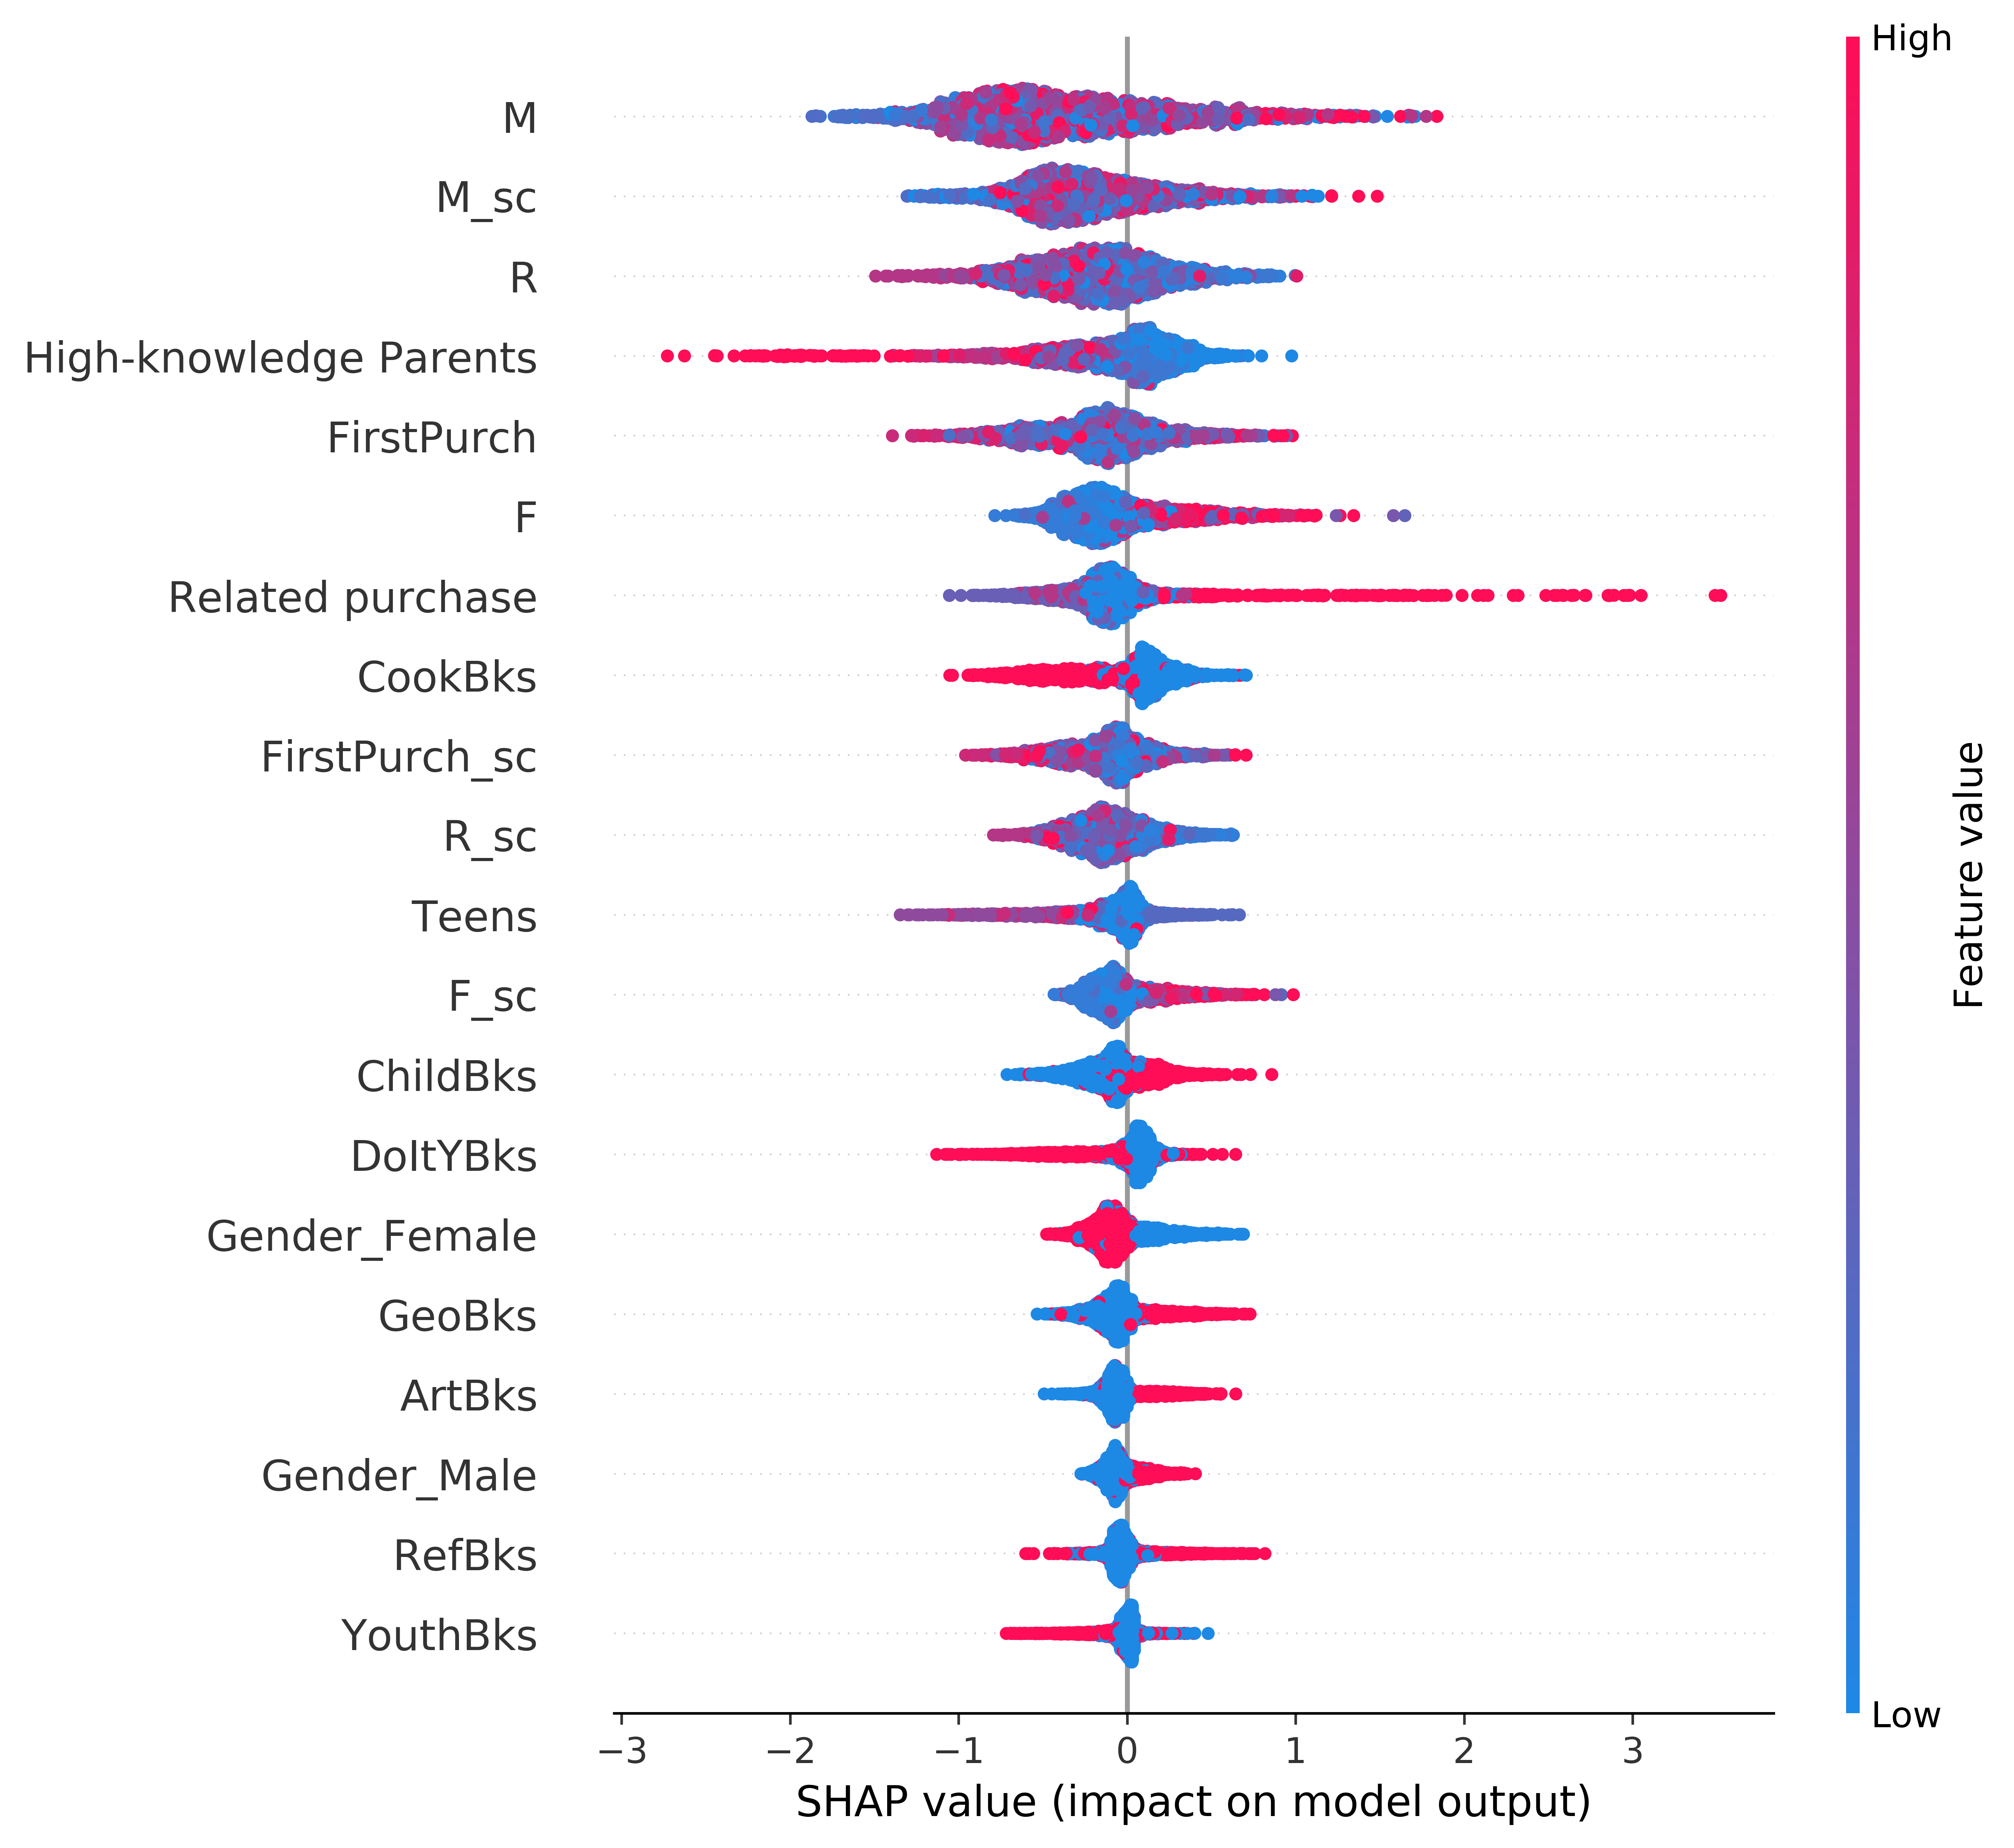

In [35]:
import shap

explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(dtrain[feature_names])

shap.summary_plot(shap_values, dtrain[feature_names])

In [36]:
from xgboost import plot_tree
plt.rcParams['savefig.dpi'] = 600 
plt.rcParams['figure.dpi'] = 600 
xgb.plot_tree(xgbmodel,num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30., 18.)
#plt.savefig("C:\\Users\\user80917\\Desktop\\CBC_dataset\\tree.png")
plt.show()

In [37]:
dMtest=xgb.DMatrix(dtest[feature_names])

preds=xgbmodel.predict(dMtest)

data_test["Florence_prob"]=preds

submission = data_test.drop(columns=['Florence'])

submission.to_csv('C:\\Users\\user80917\\Desktop\\CBC_dataset\\CBC_submission.csv', index=False, float_format='%.4f')